In [747]:
from datetime import datetime, timedelta
import pandas
from data_cache import pandas_cache
import binance
import numpy

COUNT_YEARS = 10
BINANCE_DATETIME_FORMAT = "%Y-%m-%d %H-%M-%S"

@pandas_cache("code", "year")
def load_prices(client: binance.Client, code: str, year: int):
    from_date = datetime(year, 1, 1, 0, 0, 0)
    until_date = datetime(year + 1, 1, 1, 0, 0, 0) - timedelta(seconds=1)

    # Execute the query from binance - timestamps must be converted to strings !
    candles = client.get_historical_klines(code, binance.Client.KLINE_INTERVAL_1HOUR, str(from_date), str(until_date))

    # Create a dataframe to label all the columns returned by binance so we work with them later.
    df = pandas.DataFrame(candles, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime',
                                           'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol',
                                           'ignore'])

    # as timestamp is returned in ms, let us convert this back to proper timestamps.
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df.dateTime = pandas.to_datetime(df.dateTime, unit='ms')
    df.set_index('dateTime', inplace=True)
    return df


# Create a client object
client = binance.Client()

current_year = datetime.now().year
df_years = list()
for year in range(current_year - COUNT_YEARS, current_year + 1):
    df = load_prices(client, "ETHUSDT", year)
    df = df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'], axis=1)
    df_years.append(df)

prices_df = pandas.concat(df_years, axis=0)
prices_df.index = pandas.to_datetime(prices_df.index) 

In [748]:
daily_prices = prices_df.groupby(prices_df.index.date)['open'].first()
WINDOW_PERIOD = 7

**Draw-down probability**

In [749]:
rolling_min_series = prices_df.groupby(prices_df.index.date)['low'].min().rolling(WINDOW_PERIOD).min()
period_close_series = prices_df.groupby(prices_df.index.date)['close'].last().shift(-WINDOW_PERIOD)
df = pandas.DataFrame({
    'daily_prices': daily_prices, 
    'period_close_series': period_close_series, 
    'rolling_min_series': rolling_min_series
})
df['rolling_min_series'] = df['rolling_min_series'].shift(-WINDOW_PERIOD)
df['drawdown_pct'] = -df['rolling_min_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df['period_perf_pct'] = df['period_close_series'].divide(df['daily_prices']).subtract(1.).multiply(100.)
df.dropna(inplace=True)
df.index = pandas.to_datetime(df.index) 
frequencies = dict()
for loss in range(5, 80, 5):
    frequencies[loss] = 100. * df['drawdown_pct'][df['drawdown_pct'] > loss].count() / df['drawdown_pct'].count()


<AxesSubplot: >

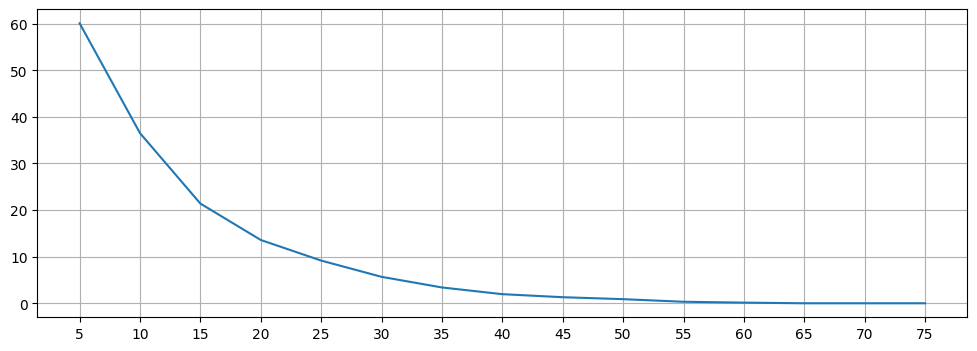

In [750]:
pandas.Series(frequencies, name='loss_distribution').plot(figsize=(12,4), grid=True, xticks=list(frequencies.keys()))

**Performance distribution**

<AxesSubplot: >

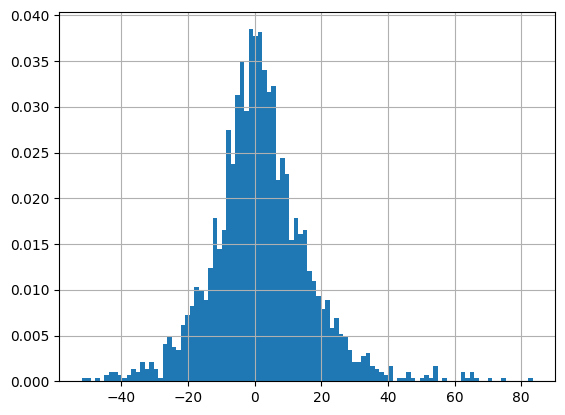

In [751]:
df['period_perf_pct'].hist(bins=100, density=True)

## Option valuation model

<AxesSubplot: >

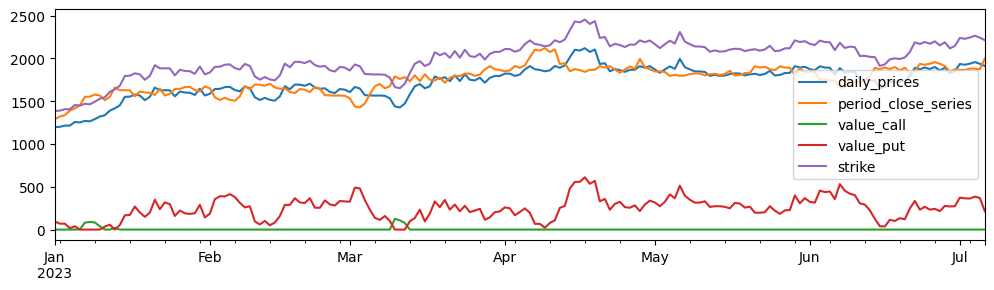

In [753]:

current_price = 1987.

def generate_strikes(price: float):
    closest_hundred = round(price / 100.) * 100.
    strikes = set()
    strikes.add(closest_hundred)
    for i in range(1, 6):
        strikes.add(closest_hundred + i * 100.)
        strikes.add(closest_hundred - i * 100.)
        
    return strikes

option_chain = list()
histograms = dict()
for strike_price in generate_strikes(current_price):
    value_call = df['period_close_series'].subtract(df['daily_prices'].multiply(strike_price / current_price))
    value_call.loc[value_call < 0.] = 0.
    value_put = df['daily_prices'].multiply(strike_price / current_price).subtract(df['period_close_series'])
    value_put.loc[value_put < 0.] = 0.
    option_chain.append({
        'strike': strike_price,
        'value_call': value_call.divide(df['daily_prices']).mean() * current_price,
        'value_put': value_put.divide(df['daily_prices']).mean() * current_price,
        'value_call_median': value_call.divide(df['daily_prices']).quantile(0.5) * current_price,
        'value_put_median': value_put.divide(df['daily_prices']).quantile(0.5) * current_price,
        'underlying_data_call': value_call.divide(df['daily_prices']),
        'underlying_data_put': value_put.divide(df['daily_prices'])
    })
    histograms[('call', strike_price)] = numpy.histogram(value_call.divide(df['daily_prices']), bins=100)
    histograms[('put', strike_price)] = numpy.histogram(value_put.divide(df['daily_prices']), bins=100)
    
df['value_call'] = value_call
df['value_put'] = value_put
df['strike'] = df['daily_prices'].multiply(strike_price / current_price)
df[['daily_prices', 'period_close_series', 'value_call', 'value_put', 'strike']][df.index.year == 2023].plot(figsize=(12,3))


In [754]:
pandas.DataFrame(option_chain).set_index('strike').sort_index()

,value_call,value_put,value_call_median,value_put_median,underlying_data_call,underlying_data_put
strike,,,,,,
1500.0,526.908614,5.210421,506.782233,0.000000,2017-08-17 0.319114 2017-08-18 0.328669 ...,2017-08-17 0.0 2017-08-18 0.0 2017-08-19...
1600.0,431.393265,9.695072,406.782233,0.000000,2017-08-17 0.268787 2017-08-18 0.278342 ...,2017-08-17 0.0 2017-08-18 0.0 2017-08-19...
1700.0,339.662474,17.964281,306.782233,0.000000,2017-08-17 0.218460 2017-08-18 0.228015 ...,2017-08-17 0.0 2017-08-18 0.0 2017-08-19...
1800.0,253.807702,32.109510,206.782233,0.000000,2017-08-17 0.168133 2017-08-18 0.177688 ...,2017-08-17 0.0 2017-08-18 0.0 2017-08-19...
1900.0,177.844656,56.146463,106.782233,0.000000,2017-08-17 0.117806 2017-08-18 0.127361 ...,2017-08-17 0.0 2017-08-18 0.0 2017-08-19...
2000.0,117.414999,95.716806,6.782233,0.000000,2017-08-17 0.067479 2017-08-18 0.077034 ...,2017-08-17 0.000000 2017-08-18 0.000000 ...
2100.0,75.203891,153.505698,0.000000,93.217767,2017-08-17 0.017152 2017-08-18 0.026707 ...,2017-08-17 0.000000 2017-08-18 0.000000 ...
2200.0,47.587417,225.889224,0.000000,193.217767,2017-08-17 0.000000 2017-08-18 0.000000 ...,2017-08-17 0.033176 2017-08-18 0.023621 ...
2300.0,29.771355,308.073162,0.000000,293.217767,2017-08-17 0.000000 2017-08-18 0.000000 ...,2017-08-17 0.083503 2017-08-18 0.073948 ...


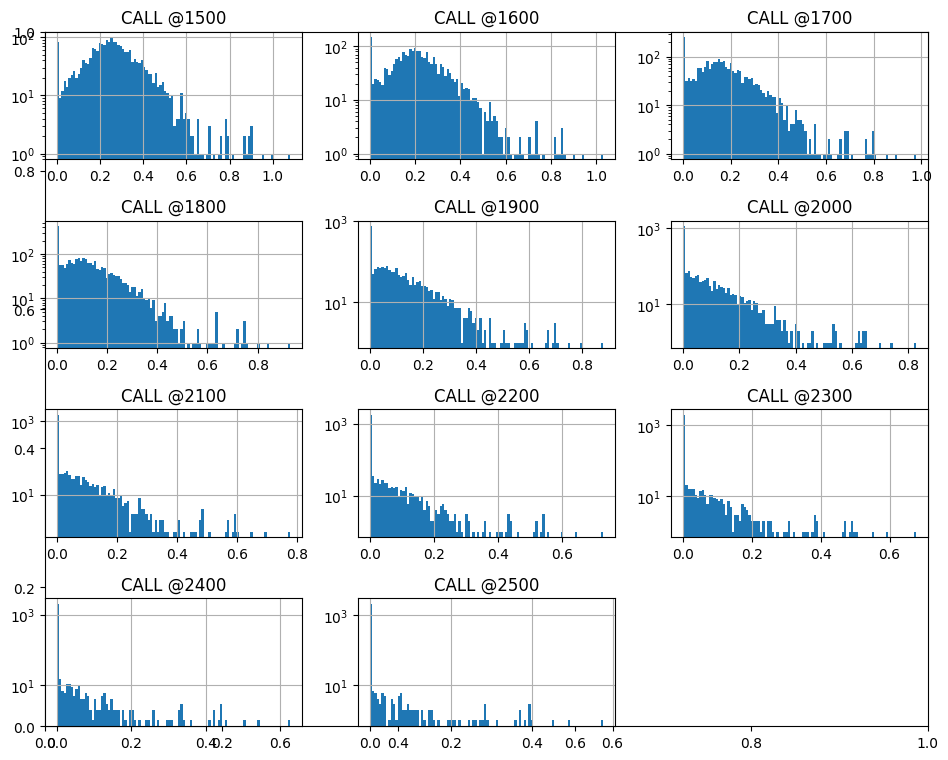

In [755]:
import numpy
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 8))

row = col = 0
for count, option_data in enumerate(sorted(option_chain, key=lambda d: d['strike'])):
    sub_ax = fig.add_subplot(4, 3, count + 1, title=f"CALL @{int(option_data['strike'])}")
    option_data['underlying_data_call'].hist(ax=sub_ax, bins=100, log=True)

# Display the plot
pyplot.tight_layout()
pyplot.show()
